# LightGBM

### Parametry:

* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
    
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Przewidujemy: *level*

In [1]:
# !pip install lightgbm==3.3.1 numpy optuna==3.3.0 scikit-learn --user

## Loading data

In [2]:
import pandas as pd
import numpy as np
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=[
        "cha",
        "con",
        "dex",
        "int",
        "str",
        "wis",
        "ac",
        "hp",
        "perception",
        "fortitude",
        "reflex",
        "will",
        "focus",
    ],
)

c:\users\pauli\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [3]:
print(df.head())

   cha  con  dex  int  str  wis  ac   hp  perception  fortitude  reflex  will  \
0    1    5    2    1    7    2  29  215          20         22      19    17   
1    1    5    0   -4    9    2  28  220          16         21      14    16   
2   -2    6    3   -4    7    3  25  175          17         20      17    15   
3    6    5    4    6    7    5  41  315          30         30      29    32   
4    1    1    3   -1   -5    1  16   20           6          6      10     4   

   focus                 book  level  
0      1  Pathfinder Bestiary     10  
1      0  Pathfinder Bestiary     10  
2      0  Pathfinder Bestiary      8  
3      1  Pathfinder Bestiary     17  
4      1  Pathfinder Bestiary      1  


## Train test split

### Chronological split

In [4]:
from training.splitting_dataset import split_dataframe
import os

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [5]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### <span style="color:red">X_train and y_train have elements of object type instead of int64. Needs fix.</span>

In [6]:
print(X_train.info())
print(X_test.info())
print(y_train.head())
print(y_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cha         841 non-null    object
 1   con         841 non-null    object
 2   dex         841 non-null    object
 3   int         841 non-null    object
 4   str         841 non-null    object
 5   wis         841 non-null    object
 6   ac          841 non-null    object
 7   hp          841 non-null    object
 8   perception  841 non-null    object
 9   fortitude   841 non-null    object
 10  reflex      841 non-null    object
 11  will        841 non-null    object
 12  focus       841 non-null    object
dtypes: object(13)
memory usage: 92.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 841 to 1205
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   cha         365 non-null    int64
 1   con         365 no

In [7]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [8]:
from training.splitting_dataset import split_dataframe

(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [9]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

### With chronological split

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

### With random split

In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

y_pred_train_random_split = gbm.predict(
    X_train_random_split, num_iteration=gbm.best_iteration
)
y_pred_test_random_split = gbm.predict(
    X_test_random_split, num_iteration=gbm.best_iteration
)


mse = mean_squared_error(y_test_random_split, y_pred_test_random_split)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111
MSE: 0.15
RMSE: 0.38


## Tuning

In [12]:
import lightgbm as lgb

print(lgb.__version__)
import optuna as lgb

print(lgb.__version__)

3.3.1
3.3.0


### With chronological split

In [13]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-08-08 20:38:58,793] A new study created in memory with name: no-name-a946a074-3281-4aa1-8cbd-14ea5a7c6bda
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.16153 + 0.0200527


feature_fraction, val_score: 0.159583:  14%|######4                                      | 1/7 [00:00<00:05,  1.10it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.166689 + 0.0187719
[200]	cv_agg's l2: 0.16294 + 0.0182487
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


feature_fraction, val_score: 0.159583:  29%|############8                                | 2/7 [00:01<00:04,  1.07it/s]

[100]	cv_agg's l2: 0.167078 + 0.0232235
[200]	cv_agg's l2: 0.165981 + 0.0231724


feature_fraction, val_score: 0.159583:  43%|###################2                         | 3/7 [00:02<00:03,  1.03it/s]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.179497 + 0.0373779


feature_fraction, val_score: 0.159583:  57%|#########################7                   | 4/7 [00:03<00:02,  1.01it/s]

[200]	cv_agg's l2: 0.175488 + 0.034751
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.177436 + 0.0335523


feature_fraction, val_score: 0.159583:  57%|#########################7                   | 4/7 [00:04<00:02,  1.01it/s]

[200]	cv_agg's l2: 0.175023 + 0.0316317
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


feature_fraction, val_score: 0.159583:  71%|################################1            | 5/7 [00:04<00:01,  1.08it/s]

[100]	cv_agg's l2: 0.189405 + 0.0383498
[200]	cv_agg's l2: 0.18619 + 0.0363794
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


feature_fraction, val_score: 0.159583:  86%|######################################5      | 6/7 [00:05<00:00,  1.11it/s]

[100]	cv_agg's l2: 0.164856 + 0.0191397


feature_fraction, val_score: 0.159583: 100%|#############################################| 7/7 [00:06<00:00,  1.10it/s]


[200]	cv_agg's l2: 0.16266 + 0.0182879
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:   5%|##5                                               | 1/20 [00:00<00:16,  1.13it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  10%|#####                                             | 2/20 [00:01<00:16,  1.10it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  10%|#####                                             | 2/20 [00:02<00:16,  1.10it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  20%|##########                                        | 4/20 [00:02<00:10,  1.56it/s]

[100]	cv_agg's l2: 0.304268 + 0.0284525
[200]	cv_agg's l2: 0.270375 + 0.0265096
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  25%|############5                                     | 5/20 [00:04<00:12,  1.21it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  30%|###############                                   | 6/20 [00:05<00:13,  1.05it/s]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  35%|#################5                                | 7/20 [00:06<00:13,  1.07s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  40%|####################                              | 8/20 [00:07<00:13,  1.11s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  45%|######################5                           | 9/20 [00:09<00:12,  1.14s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  50%|########################5                        | 10/20 [00:10<00:11,  1.20s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  55%|##########################9                      | 11/20 [00:11<00:11,  1.27s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  60%|#############################4                   | 12/20 [00:14<00:12,  1.58s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  65%|###############################8                 | 13/20 [00:15<00:11,  1.58s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  70%|##################################3              | 14/20 [00:16<00:08,  1.49s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  75%|####################################7            | 15/20 [00:18<00:06,  1.39s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  80%|#######################################2         | 16/20 [00:19<00:05,  1.31s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  85%|#########################################6       | 17/20 [00:20<00:04,  1.35s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  90%|############################################1    | 18/20 [00:22<00:02,  1.38s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583:  95%|##############################################5  | 19/20 [00:23<00:01,  1.32s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611


num_leaves, val_score: 0.159583: 100%|#################################################| 20/20 [00:24<00:00,  1.21s/it]


Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


bagging, val_score: 0.159583:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.217635 + 0.027276


bagging, val_score: 0.159583:  10%|#####3                                               | 1/10 [00:00<00:06,  1.36it/s]

[200]	cv_agg's l2: 0.200355 + 0.02192
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.158981 + 0.016822
[200]	cv_agg's l2: 0.157295 + 0.0160732


bagging, val_score: 0.156907:  20%|##########6                                          | 2/10 [00:01<00:07,  1.08it/s]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.156907 + 0.0151951
[100]	cv_agg's l2: 0.155916 + 0.018413
[200]	cv_agg's l2: 0.154989 + 0.017604


bagging, val_score: 0.154844:  30%|###############9                                     | 3/10 [00:03<00:08,  1.21s/it]

[300]	cv_agg's l2: 0.155503 + 0.0169166
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.154844 + 0.0172584
[100]	cv_agg's l2: 0.16137 + 0.0204136
[200]	cv_agg's l2: 0.159734 + 0.0181865
[300]	cv_agg's l2: 0.160495 + 0.01836
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.154844 + 0.0172584


bagging, val_score: 0.154844:  40%|#####################2                               | 4/10 [00:04<00:07,  1.30s/it]

[100]	cv_agg's l2: 0.160056 + 0.0192815
[200]	cv_agg's l2: 0.159608 + 0.0183451


bagging, val_score: 0.154844:  50%|##########################5                          | 5/10 [00:06<00:07,  1.40s/it]

[300]	cv_agg's l2: 0.160506 + 0.0171359
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.154844 + 0.0172584
[100]	cv_agg's l2: 0.163091 + 0.0217372
[200]	cv_agg's l2: 0.158875 + 0.0184399
[300]	cv_agg's l2: 0.157365 + 0.0171511
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.154844 + 0.0172584


bagging, val_score: 0.154844:  60%|###############################8                     | 6/10 [00:07<00:05,  1.43s/it]

[100]	cv_agg's l2: 0.157109 + 0.016518
[200]	cv_agg's l2: 0.154617 + 0.0155459
[300]	cv_agg's l2: 0.155032 + 0.01614
Early stopping, best iteration is:
[235]	cv_agg's l2: 0.154004 + 0.015837


bagging, val_score: 0.154004:  70%|#####################################                | 7/10 [00:09<00:04,  1.42s/it]

[100]	cv_agg's l2: 0.160543 + 0.0166317
[200]	cv_agg's l2: 0.15931 + 0.01614


bagging, val_score: 0.154004:  80%|##########################################4          | 8/10 [00:10<00:02,  1.47s/it]

[300]	cv_agg's l2: 0.159203 + 0.0156095
Early stopping, best iteration is:
[235]	cv_agg's l2: 0.154004 + 0.015837
[100]	cv_agg's l2: 0.154721 + 0.0184412


bagging, val_score: 0.152692:  80%|##########################################4          | 8/10 [00:11<00:02,  1.47s/it]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905


bagging, val_score: 0.152692:  90%|###############################################7     | 9/10 [00:11<00:01,  1.36s/it]

[100]	cv_agg's l2: 0.166487 + 0.0228445
[200]	cv_agg's l2: 0.160733 + 0.018057
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905


feature_fraction_stage2, val_score: 0.152692:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165277 + 0.0212035
[200]	cv_agg's l2: 0.162209 + 0.0185305


feature_fraction_stage2, val_score: 0.152692:  33%|############6                         | 1/3 [00:01<00:03,  1.70s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


feature_fraction_stage2, val_score: 0.152692:  67%|#########################3            | 2/3 [00:03<00:01,  1.55s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.165277 + 0.0212035
[200]	cv_agg's l2: 0.162209 + 0.0185305


feature_fraction_stage2, val_score: 0.152692: 100%|######################################| 3/3 [00:04<00:00,  1.49s/it]


Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905


regularization_factors, val_score: 0.152692:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.210638 + 0.034404
[200]	cv_agg's l2: 0.202178 + 0.0322065


regularization_factors, val_score: 0.152692:   5%|#9                                    | 1/20 [00:00<00:10,  1.81it/s]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  10%|###8                                  | 2/20 [00:02<00:20,  1.17s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  15%|#####7                                | 3/20 [00:03<00:24,  1.43s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  20%|#######6                              | 4/20 [00:04<00:20,  1.29s/it]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  25%|#########5                            | 5/20 [00:06<00:20,  1.38s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  30%|###########4                          | 6/20 [00:08<00:20,  1.44s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  35%|#############3                        | 7/20 [00:09<00:18,  1.45s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  40%|###############2                      | 8/20 [00:10<00:17,  1.44s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  45%|#################1                    | 9/20 [00:12<00:16,  1.51s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634


regularization_factors, val_score: 0.152692:  50%|##################5                  | 10/20 [00:14<00:15,  1.56s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412
[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905


regularization_factors, val_score: 0.152692:  55%|####################3                | 11/20 [00:15<00:12,  1.44s/it]

[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  60%|######################2              | 12/20 [00:16<00:10,  1.31s/it]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  65%|########################             | 13/20 [00:17<00:08,  1.22s/it]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  70%|#########################9           | 14/20 [00:18<00:06,  1.12s/it]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  75%|###########################7         | 15/20 [00:19<00:05,  1.08s/it]

[200]	cv_agg's l2: 0.153815 + 0.0177404
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  80%|#############################6       | 16/20 [00:20<00:04,  1.03s/it]

[200]	cv_agg's l2: 0.1537 + 0.0176736
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  85%|###############################4     | 17/20 [00:21<00:02,  1.00it/s]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  90%|#################################3   | 18/20 [00:22<00:01,  1.03it/s]

[200]	cv_agg's l2: 0.1537 + 0.0176736
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692:  95%|###################################1 | 19/20 [00:23<00:00,  1.03it/s]

[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905
[100]	cv_agg's l2: 0.154721 + 0.0184412


regularization_factors, val_score: 0.152692: 100%|#####################################| 20/20 [00:24<00:00,  1.21s/it]


[200]	cv_agg's l2: 0.153631 + 0.017634
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.152692 + 0.0175905


min_data_in_leaf, val_score: 0.152692:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.143268 + 0.0132265
[200]	cv_agg's l2: 0.141448 + 0.0131666
[300]	cv_agg's l2: 0.1408 + 0.0132666


min_data_in_leaf, val_score: 0.140712:  20%|#########                                    | 1/5 [00:01<00:07,  1.94s/it]

[400]	cv_agg's l2: 0.140774 + 0.0132473
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.140712 + 0.0131763
[100]	cv_agg's l2: 0.174662 + 0.0202721
[200]	cv_agg's l2: 0.168099 + 0.0163938
[300]	cv_agg's l2: 0.167474 + 0.0155254


min_data_in_leaf, val_score: 0.140712:  40%|##################                           | 2/5 [00:03<00:04,  1.58s/it]

[400]	cv_agg's l2: 0.167684 + 0.0154575
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.140712 + 0.0131763
[100]	cv_agg's l2: 0.140139 + 0.0125047
[200]	cv_agg's l2: 0.139331 + 0.0121431


min_data_in_leaf, val_score: 0.139218:  60%|###########################                  | 3/5 [00:04<00:02,  1.50s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.139218 + 0.0121022
[100]	cv_agg's l2: 0.833317 + 0.139641
[200]	cv_agg's l2: 0.80305 + 0.147838


min_data_in_leaf, val_score: 0.139218:  80%|####################################         | 4/5 [00:05<00:01,  1.12s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.139218 + 0.0121022
[100]	cv_agg's l2: 0.248135 + 0.0223375
[200]	cv_agg's l2: 0.23056 + 0.0261669


min_data_in_leaf, val_score: 0.139218: 100%|#############################################| 5/5 [00:05<00:00,  1.17s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.139218 + 0.0121022


In [14]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1392182981112245
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.7411338166394333e-07
    lambda_l2: 4.39802060157749e-06
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.937718545708761
    bagging_freq: 1
    min_child_samples: 10


In [15]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

y_pred = lgb_tuned.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.20
RMSE: 0.45


Really good results.

#### Rounded results

In [16]:
predict = lgb_tuned.predict(X_test)
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold33 = 0.33
round_predict_lower_threshold33 = np.where(
    (predict % 1) > threshold33, np.ceil(predict), np.floor(predict)
).astype("int")
threshold45 = 0.45
round_predict_lower_threshold45 = np.where(
    (predict % 1) > threshold45, np.ceil(predict), np.floor(predict)
).astype("int")

In [17]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print()

In [18]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

print("Round lower threshold = 0.33:")
check_predictions(y_test, round_predict_lower_threshold33)

print("Round lower threshold = 0.45:")
check_predictions(y_test, round_predict_lower_threshold45)

Normal:
Mean square error: 0.20
RMSE: 0.45

Round:
Mean square error: 0.22
RMSE: 0.47

Round lower threshold = 0.33:
Mean square error: 0.24
RMSE: 0.49

Round lower threshold = 0.45:
Mean square error: 0.22
RMSE: 0.47



#### Confusion matrix

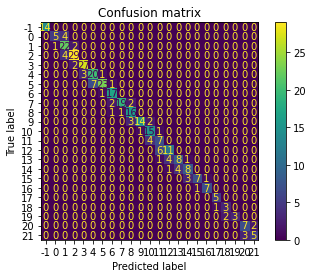

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, round_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

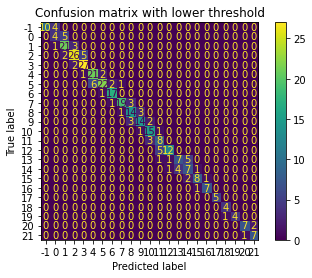

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, round_predict_lower_threshold33)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix with lower threshold")
plt.show()

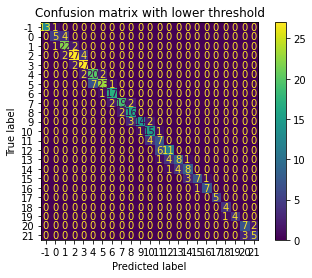

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, round_predict_lower_threshold45)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix with lower threshold")
plt.show()

Predicted values still tend to be lower than real ones, but lowering threshold doesn't help. It usually makes predictions too high. I would leave threshold at 0.5.

### With random split

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-08-08 20:40:30,498] A new study created in memory with name: no-name-7d1609d6-62e0-4c93-9991-78d7bf30b78d
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.181112 + 0.0407863
[200]	cv_agg's l2: 0.180945 + 0.0392632


feature_fraction, val_score: 0.180415:  14%|######4                                      | 1/7 [00:01<00:06,  1.13s/it]

Early stopping, best iteration is:
[161]	cv_agg's l2: 0.180415 + 0.0396566
[100]	cv_agg's l2: 0.171143 + 0.0324049
[200]	cv_agg's l2: 0.171826 + 0.0303752


feature_fraction, val_score: 0.171004:  29%|############8                                | 2/7 [00:03<00:08,  1.69s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.171004 + 0.0312126
[100]	cv_agg's l2: 0.166328 + 0.0217212
[200]	cv_agg's l2: 0.165723 + 0.021112


feature_fraction, val_score: 0.165202:  43%|###################2                         | 3/7 [00:05<00:07,  1.84s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.165202 + 0.0205454
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


feature_fraction, val_score: 0.163729:  57%|#########################7                   | 4/7 [00:06<00:05,  1.81s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.192615 + 0.0409583
[200]	cv_agg's l2: 0.190623 + 0.0405489


feature_fraction, val_score: 0.163729:  71%|################################1            | 5/7 [00:08<00:03,  1.81s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.193393 + 0.0521645
[200]	cv_agg's l2: 0.192682 + 0.051388


feature_fraction, val_score: 0.163729:  86%|######################################5      | 6/7 [00:10<00:01,  1.60s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164372 + 0.0259736
[200]	cv_agg's l2: 0.167231 + 0.0220458


feature_fraction, val_score: 0.163729: 100%|#############################################| 7/7 [00:11<00:00,  1.61s/it]


Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:   5%|##5                                               | 1/20 [00:01<00:21,  1.13s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  10%|#####                                             | 2/20 [00:02<00:21,  1.17s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  15%|#######5                                          | 3/20 [00:03<00:19,  1.17s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164735 + 0.0232089


num_leaves, val_score: 0.163238:  20%|##########                                        | 4/20 [00:04<00:16,  1.05s/it]

[200]	cv_agg's l2: 0.163849 + 0.0208748
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.202401 + 0.0414176
[200]	cv_agg's l2: 0.184724 + 0.0356359
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635


num_leaves, val_score: 0.163238:  25%|############5                                     | 5/20 [00:04<00:12,  1.23it/s]

[100]	cv_agg's l2: 0.164527 + 0.0237482


num_leaves, val_score: 0.163238:  30%|###############                                   | 6/20 [00:05<00:13,  1.05it/s]

[200]	cv_agg's l2: 0.165579 + 0.0208101
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  35%|#################5                                | 7/20 [00:06<00:12,  1.04it/s]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  40%|####################                              | 8/20 [00:07<00:11,  1.02it/s]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  45%|######################5                           | 9/20 [00:09<00:11,  1.01s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  50%|########################5                        | 10/20 [00:10<00:10,  1.02s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  55%|##########################9                      | 11/20 [00:11<00:08,  1.00it/s]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  60%|#############################4                   | 12/20 [00:12<00:08,  1.05s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.209093 + 0.0397164
[200]	cv_agg's l2: 0.184882 + 0.0291755


num_leaves, val_score: 0.163238:  65%|###############################8                 | 13/20 [00:12<00:06,  1.15it/s]

Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  70%|##################################3              | 14/20 [00:14<00:06,  1.02s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  75%|####################################7            | 15/20 [00:15<00:05,  1.05s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163238:  80%|#######################################2         | 16/20 [00:16<00:04,  1.22s/it]

Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  85%|#########################################6       | 17/20 [00:17<00:03,  1.17s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  90%|############################################1    | 18/20 [00:19<00:02,  1.23s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238:  95%|##############################################5  | 19/20 [00:20<00:01,  1.22s/it]

[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164516 + 0.0237532


num_leaves, val_score: 0.163238: 100%|#################################################| 20/20 [00:21<00:00,  1.08s/it]


[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635


bagging, val_score: 0.163238:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.194398 + 0.0301136


bagging, val_score: 0.163238:  10%|#####3                                               | 1/10 [00:00<00:06,  1.41it/s]

[200]	cv_agg's l2: 0.19213 + 0.0303916
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.170704 + 0.0273397


bagging, val_score: 0.163238:  20%|##########6                                          | 2/10 [00:01<00:07,  1.07it/s]

[200]	cv_agg's l2: 0.172126 + 0.0248819
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.210731 + 0.022628


bagging, val_score: 0.163238:  30%|###############9                                     | 3/10 [00:02<00:05,  1.26it/s]

[200]	cv_agg's l2: 0.200944 + 0.0160967
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.183211 + 0.0313644


bagging, val_score: 0.163238:  40%|#####################2                               | 4/10 [00:03<00:05,  1.17it/s]

[200]	cv_agg's l2: 0.175795 + 0.0281843
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.174624 + 0.0247677


bagging, val_score: 0.163238:  50%|##########################5                          | 5/10 [00:04<00:04,  1.15it/s]

[200]	cv_agg's l2: 0.169984 + 0.0200838
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.165895 + 0.0237858


bagging, val_score: 0.163238:  60%|###############################8                     | 6/10 [00:05<00:03,  1.05it/s]

[200]	cv_agg's l2: 0.165284 + 0.0205651
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.174548 + 0.0276356


bagging, val_score: 0.163238:  70%|#####################################                | 7/10 [00:06<00:02,  1.07it/s]

[200]	cv_agg's l2: 0.173131 + 0.0256871
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.18428 + 0.0260197


bagging, val_score: 0.163238:  80%|##########################################4          | 8/10 [00:07<00:01,  1.13it/s]

[200]	cv_agg's l2: 0.180662 + 0.024673
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.218521 + 0.0195802


bagging, val_score: 0.163238:  90%|###############################################7     | 9/10 [00:07<00:00,  1.20it/s]

[200]	cv_agg's l2: 0.209434 + 0.0171503
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.189778 + 0.0226125


bagging, val_score: 0.163238: 100%|####################################################| 10/10 [00:08<00:00,  1.17it/s]


[200]	cv_agg's l2: 0.182665 + 0.0192835
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635


feature_fraction_stage2, val_score: 0.163238:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164735 + 0.0232089


feature_fraction_stage2, val_score: 0.163238:  17%|######3                               | 1/6 [00:01<00:05,  1.12s/it]

[200]	cv_agg's l2: 0.163849 + 0.0208748
Early stopping, best iteration is:
[125]	cv_agg's l2: 0.163238 + 0.0221635
[100]	cv_agg's l2: 0.164214 + 0.0264057
[200]	cv_agg's l2: 0.163655 + 0.0245607


feature_fraction_stage2, val_score: 0.162721:  33%|############6                         | 2/6 [00:02<00:04,  1.15s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185
[100]	cv_agg's l2: 0.164666 + 0.0208879
[200]	cv_agg's l2: 0.164267 + 0.0193142


feature_fraction_stage2, val_score: 0.162721:  50%|###################                   | 3/6 [00:03<00:04,  1.38s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185
[100]	cv_agg's l2: 0.164735 + 0.0232089
[200]	cv_agg's l2: 0.163849 + 0.0208748


feature_fraction_stage2, val_score: 0.162721:  67%|#########################3            | 4/6 [00:05<00:02,  1.43s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185
[100]	cv_agg's l2: 0.163903 + 0.0232595
[200]	cv_agg's l2: 0.164668 + 0.0217348


feature_fraction_stage2, val_score: 0.162721:  83%|###############################6      | 5/6 [00:06<00:01,  1.40s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185
[100]	cv_agg's l2: 0.163903 + 0.0232595
[200]	cv_agg's l2: 0.164668 + 0.0217348


feature_fraction_stage2, val_score: 0.162721: 100%|######################################| 6/6 [00:08<00:00,  1.35s/it]


Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185


regularization_factors, val_score: 0.162721:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.163561 + 0.0266011
[200]	cv_agg's l2: 0.164162 + 0.0246733


regularization_factors, val_score: 0.162721:   5%|#9                                    | 1/20 [00:01<00:36,  1.92s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.162721 + 0.0246185
[100]	cv_agg's l2: 0.163404 + 0.0266515
[200]	cv_agg's l2: 0.16421 + 0.0246623


regularization_factors, val_score: 0.162463:  10%|###8                                  | 2/20 [00:04<00:46,  2.58s/it]

Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163561 + 0.0266013


regularization_factors, val_score: 0.162463:  15%|#####7                                | 3/20 [00:08<00:50,  2.94s/it]

[200]	cv_agg's l2: 0.164085 + 0.0245399
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163561 + 0.0266012


regularization_factors, val_score: 0.162463:  20%|#######6                              | 4/20 [00:09<00:37,  2.37s/it]

[200]	cv_agg's l2: 0.164085 + 0.0245398
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163561 + 0.0266011
[200]	cv_agg's l2: 0.164162 + 0.0246733
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515


regularization_factors, val_score: 0.162463:  25%|#########5                            | 5/20 [00:11<00:30,  2.06s/it]

[100]	cv_agg's l2: 0.163561 + 0.0266011


regularization_factors, val_score: 0.162463:  30%|###########4                          | 6/20 [00:12<00:25,  1.81s/it]

[200]	cv_agg's l2: 0.164162 + 0.0246733
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163561 + 0.0266013


regularization_factors, val_score: 0.162463:  35%|#############3                        | 7/20 [00:13<00:20,  1.59s/it]

[200]	cv_agg's l2: 0.164085 + 0.0245399
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163561 + 0.0266013


regularization_factors, val_score: 0.162463:  40%|###############2                      | 8/20 [00:14<00:16,  1.40s/it]

[200]	cv_agg's l2: 0.164085 + 0.02454
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.163326 + 0.026678


regularization_factors, val_score: 0.162463:  45%|#################1                    | 9/20 [00:15<00:13,  1.27s/it]

[200]	cv_agg's l2: 0.164705 + 0.0244307
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.162463 + 0.0252515
[100]	cv_agg's l2: 0.162703 + 0.0268688


regularization_factors, val_score: 0.162202:  50%|##################5                  | 10/20 [00:16<00:11,  1.16s/it]

[200]	cv_agg's l2: 0.163457 + 0.0256982
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.162202 + 0.0263863
[100]	cv_agg's l2: 0.162901 + 0.0222928


regularization_factors, val_score: 0.162202:  55%|####################3                | 11/20 [00:17<00:09,  1.06s/it]

[200]	cv_agg's l2: 0.163132 + 0.0206252
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.162202 + 0.0263863
[100]	cv_agg's l2: 0.167735 + 0.0216534


regularization_factors, val_score: 0.162202:  60%|######################2              | 12/20 [00:18<00:08,  1.01s/it]

[200]	cv_agg's l2: 0.167755 + 0.0183896
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.162202 + 0.0263863
[100]	cv_agg's l2: 0.161109 + 0.0249455


regularization_factors, val_score: 0.160317:  65%|########################             | 13/20 [00:19<00:07,  1.11s/it]

[200]	cv_agg's l2: 0.162635 + 0.0206023
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.163839 + 0.0217757


regularization_factors, val_score: 0.160317:  70%|#########################9           | 14/20 [00:20<00:06,  1.13s/it]

[200]	cv_agg's l2: 0.163586 + 0.0205777
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.162629 + 0.0248306


regularization_factors, val_score: 0.160317:  75%|###########################7         | 15/20 [00:22<00:05,  1.11s/it]

[200]	cv_agg's l2: 0.162507 + 0.0211521
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.163676 + 0.0232908


regularization_factors, val_score: 0.160317:  80%|#############################6       | 16/20 [00:22<00:04,  1.08s/it]

[200]	cv_agg's l2: 0.163861 + 0.0204097
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.165114 + 0.0251456


regularization_factors, val_score: 0.160317:  85%|###############################4     | 17/20 [00:24<00:03,  1.09s/it]

[200]	cv_agg's l2: 0.16525 + 0.0221621
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.164822 + 0.025432


regularization_factors, val_score: 0.160317:  90%|#################################3   | 18/20 [00:25<00:02,  1.08s/it]

[200]	cv_agg's l2: 0.165742 + 0.023093
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.162203 + 0.0231682


regularization_factors, val_score: 0.160317:  95%|###################################1 | 19/20 [00:26<00:01,  1.07s/it]

[200]	cv_agg's l2: 0.163689 + 0.0207418
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546
[100]	cv_agg's l2: 0.162077 + 0.0219677


regularization_factors, val_score: 0.160317: 100%|#####################################| 20/20 [00:27<00:00,  1.37s/it]


[200]	cv_agg's l2: 0.163009 + 0.0203369
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160317 + 0.0245546


min_data_in_leaf, val_score: 0.160317:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.152861 + 0.0279081


min_data_in_leaf, val_score: 0.151315:  20%|#########                                    | 1/5 [00:00<00:03,  1.05it/s]

[200]	cv_agg's l2: 0.152436 + 0.0263551
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.151315 + 0.0269636
[100]	cv_agg's l2: 0.231904 + 0.0286348


min_data_in_leaf, val_score: 0.151315:  40%|##################                           | 2/5 [00:01<00:02,  1.41it/s]

[200]	cv_agg's l2: 0.223753 + 0.0292532
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.151315 + 0.0269636
[100]	cv_agg's l2: 0.181694 + 0.0241446


min_data_in_leaf, val_score: 0.151315:  60%|###########################                  | 3/5 [00:02<00:01,  1.23it/s]

[200]	cv_agg's l2: 0.177776 + 0.0226523
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.151315 + 0.0269636
[100]	cv_agg's l2: 0.663683 + 0.0645735
[200]	cv_agg's l2: 0.634658 + 0.0646756


min_data_in_leaf, val_score: 0.151315:  80%|####################################         | 4/5 [00:02<00:00,  1.54it/s]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.151315 + 0.0269636
[100]	cv_agg's l2: 0.155959 + 0.0222376
[200]	cv_agg's l2: 0.154208 + 0.0191007


min_data_in_leaf, val_score: 0.151315: 100%|#############################################| 5/5 [00:04<00:00,  1.22it/s]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.151315 + 0.0269636


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15131475027344737
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.0205466793661569e-08
    lambda_l2: 0.027977302555445407
    num_leaves: 25
    feature_fraction: 0.58
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

y_pred_random_split = lgb_tuned.predict(X_test_random_split)

mse = mean_squared_error(y_test_random_split, y_pred_random_split)
rmse = mean_squared_error(y_test_random_split, y_pred_random_split, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.11
RMSE: 0.34


#### Rounded results

In [25]:
predict = lgb_tuned.predict(X_test_random_split)
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold = 0.33
round_predict_lower_threshold33 = np.where(
    (predict % 1) > threshold, np.ceil(predict), np.floor(predict)
).astype("int")
threshold45 = 0.45
round_predict_lower_threshold45 = np.where(
    (predict % 1) > threshold45, np.ceil(predict), np.floor(predict)
).astype("int")

In [26]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print()

In [27]:
print("Normal:")
check_predictions(y_test_random_split, predict)

print("Round:")
check_predictions(y_test_random_split, round_predict)

print("Round lower threshold =0.33:")
check_predictions(y_test_random_split, round_predict_lower_threshold33)

print("Round lower threshold = 0.45:")
check_predictions(y_test_random_split, round_predict_lower_threshold45)

Normal:
Mean square error: 0.11
RMSE: 0.34

Round:
Mean square error: 0.11
RMSE: 0.33

Round lower threshold =0.33:
Mean square error: 0.19
RMSE: 0.43

Round lower threshold = 0.45:
Mean square error: 0.11
RMSE: 0.33



#### Confusion matrix

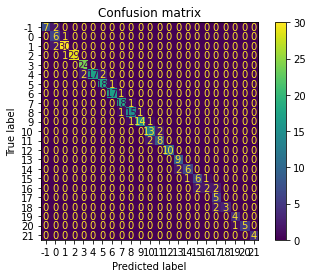

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_random_split, round_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

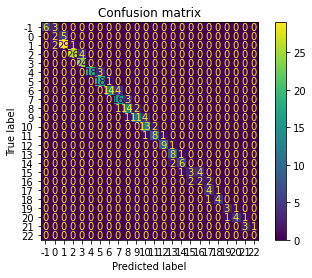

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_random_split, round_predict_lower_threshold33)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 23))

disp.plot()
plt.title("Confusion matrix")
plt.show()

Here lower threshold works even worse.

In [31]:
# save model to file
# gbm.save_model('model.txt')

Summary:
* best results
* set threshold to 0.5